In [29]:
import random
import math
import matplotlib.pyplot as plt

In [30]:
def read_tsp(filename):
    coords = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                x, y = float(parts[1]), float(parts[2])
                coords.append((x, y))
    if not coords:
        raise ValueError("File .tsp không hợp lệ: không đọc được tọa độ")

    n = len(coords)
    dist_matrix = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                xi, yi = coords[i]
                xj, yj = coords[j]
                dist_matrix[i][j] = round(math.hypot(xi - xj, yi - yj))
    return dist_matrix

In [31]:
class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = None
    def copy(self):
        ind = Individual(self.genome.copy())
        ind.fitness = self.fitness
        return ind

In [32]:
class TSP:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.num_cities = len(distance_matrix)

    def evaluate(self, individual):
        dist = 0
        genome = individual.genome
        for i in range(self.num_cities):
            dist += self.distance_matrix[genome[i]][genome[(i + 1) % self.num_cities]]
        individual.fitness = dist
        return individual

    def generate_genome(self):
        return random.sample(range(self.num_cities), self.num_cities)

In [33]:
def order_crossover(parent1_genome, parent2_genome):
    n = len(parent1_genome)
    child1 = [None] * n
    child2 = [None] * n

    start = random.randint(0, n - 2)
    end = random.randint(start + 1, n)

    child1[start:end] = parent1_genome[start:end]
    child2[start:end] = parent2_genome[start:end]

    fill1 = [gene for gene in parent2_genome if gene not in child1[start:end]]
    fill2 = [gene for gene in parent1_genome if gene not in child2[start:end]]

    j = 0
    for i in range(n):
        if child1[i] is None:
            child1[i] = fill1[j]
            j += 1

    j = 0
    for i in range(n):
        if child2[i] is None:
            child2[i] = fill2[j]
            j += 1

    return child1, child2


In [34]:
def swap_mutation(genome):
    if len(genome) < 2:
        return genome.copy()
    g = genome.copy()
    i, j = random.sample(range(len(g)), 2)
    g[i], g[j] = g[j], g[i]
    return g


In [35]:
class GA:
    def __init__(self, problem, seed, pop_size=100, n_gen=500, crossover_rate=0.9, mutation_rate=0.1):
        self.problem = problem
        self.seed = seed
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population = []

    def initialize(self):
        random.seed(self.seed)
        self.population = [Individual(self.problem.generate_genome()) for _ in range(self.pop_size)]
        for ind in self.population:
            self.problem.evaluate(ind)

    def evaluate(self):
        for ind in self.population:
            self.problem.evaluate(ind)

    def select(self, tournament_size=3):
        selected = []
        for _ in range(self.pop_size):
            tournament = random.sample(self.population, tournament_size)
            winner = min(tournament, key=lambda ind: ind.fitness)
            selected.append(winner.copy())
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            g1, g2 = order_crossover(parent1.genome, parent2.genome)
            return Individual(g1), Individual(g2)
        else:
            return parent1.copy(), parent2.copy()

    def mutation(self, individual):
        if random.random() < self.mutation_rate:
            g = swap_mutation(individual.genome)
            return Individual(g)
        else:
            return individual.copy()

    # def run(self):
    #     self.initialize()
    #     best = min(self.population, key=lambda ind: ind.fitness)

    #     for gen in range(self.n_gen):
    #         selected = self.selection()
    #         next_pop = self.population
    #         for i in range(0, self.pop_size, 2):
    #             p1, p2 = selected[i], selected[(i+1) % self.pop_size]
    #             c1, c2 = self.crossover(p1, p2)
    #             next_pop.append(self.mutation(c1))
    #             next_pop.append(self.mutation(c2))
    #         selected = self.selection(tournament_size=5)
    #         self.population = selected
    #         self.evaluate()
    #         current_best = min(self.population, key=lambda ind: ind.fitness)
    #         if current_best.fitness < best.fitness:
    #             best = current_best.copy()

    #         print(f"Gen {gen+1}, best fitness: {best.fitness}")

    #     return best
    
    def run(self):
        self.initialize()
        # initial best
        best = min(self.population, key=lambda ind: ind.fitness).copy()
        best_history = [best.fitness]

        for gen in range(self.n_gen):
            selected = self.select()
            next_pop = self.population.copy()  

            for i in range(0, self.pop_size, 2):
                p1, p2 = selected[i], selected[(i+1) % self.pop_size]
                c1, c2 = self.crossover(p1, p2)
                next_pop.append(self.mutation(c1))
                next_pop.append(self.mutation(c2))

            self.population = next_pop
            self.evaluate()

            self.population.sort(key=lambda ind: ind.fitness)
            self.population = [ind.copy() for ind in self.population[:self.pop_size]]
            current_best = self.population[0]

            random.shuffle(self.population)

            if current_best.fitness < best.fitness:
                best = current_best.copy()

            best_history.append(best.fitness)

        return best, best_history

In [36]:
class Experiment:
    def __init__(self, algo, problem, seed_list=range(30), **algo_kwards):
        self.algo = algo
        self.problem = problem
        self.seeds = seed_list
        self.algo_kwards = algo_kwards
    
    def run(self):
        result = []
        all_histories = []

        for i, seed in enumerate(self.seeds):
            algorithm = self.algo(self.problem, seed, **self.algo_kwards)

            best, history = algorithm.run()
            all_histories.append(history)
            
            print(f"Seed {i}, best = {best.fitness}, genome = {best.genome}")
            result.append(best)

        return result, all_histories


In [37]:
if __name__ == "__main__":
    filename = "/Users/Prj TTTH/EC-lab/dataset/tsp/eil51.tsp"
    distance_matrix = read_tsp(filename)
    problem = TSP(distance_matrix)

    exp = Experiment(GA, problem, seed_list=range(30),
                     pop_size=100, n_gen=500,
                     crossover_rate=0.9, mutation_rate=0.1)
    results, all_histories = exp.run()

    best = min(results, key=lambda ind: ind.fitness)
    print(f"Best overall fitness: {best.fitness}")
    print(f"Best genome (tour): {best.genome}")


Seed 0, best = 575, genome = [30, 25, 6, 47, 7, 1, 15, 37, 8, 4, 36, 16, 17, 5, 22, 42, 23, 13, 24, 12, 40, 39, 18, 41, 11, 10, 28, 19, 34, 35, 21, 0, 26, 31, 48, 9, 29, 49, 20, 33, 38, 32, 44, 14, 43, 3, 46, 50, 45, 2, 27]
Seed 1, best = 523, genome = [26, 50, 45, 46, 43, 41, 39, 18, 40, 12, 17, 3, 16, 11, 37, 19, 34, 35, 31, 10, 4, 36, 14, 44, 32, 38, 29, 9, 48, 8, 15, 49, 33, 20, 28, 1, 0, 21, 2, 27, 30, 25, 6, 42, 23, 24, 13, 5, 22, 47, 7]
Seed 2, best = 523, genome = [8, 48, 16, 18, 40, 39, 41, 43, 14, 36, 11, 45, 26, 0, 21, 2, 35, 34, 19, 28, 20, 33, 29, 9, 38, 32, 44, 4, 10, 31, 1, 27, 30, 7, 25, 6, 42, 23, 22, 47, 5, 50, 46, 17, 13, 24, 12, 3, 37, 15, 49]
Seed 3, best = 600, genome = [37, 48, 38, 9, 4, 11, 46, 24, 23, 42, 22, 6, 25, 7, 47, 14, 44, 32, 31, 0, 21, 2, 35, 34, 19, 28, 20, 36, 16, 43, 41, 18, 39, 40, 12, 3, 17, 13, 5, 26, 50, 45, 10, 15, 8, 29, 33, 49, 1, 27, 30]
Seed 4, best = 556, genome = [36, 4, 15, 20, 33, 49, 8, 48, 37, 10, 31, 7, 25, 30, 21, 1, 29, 9, 38, 32,

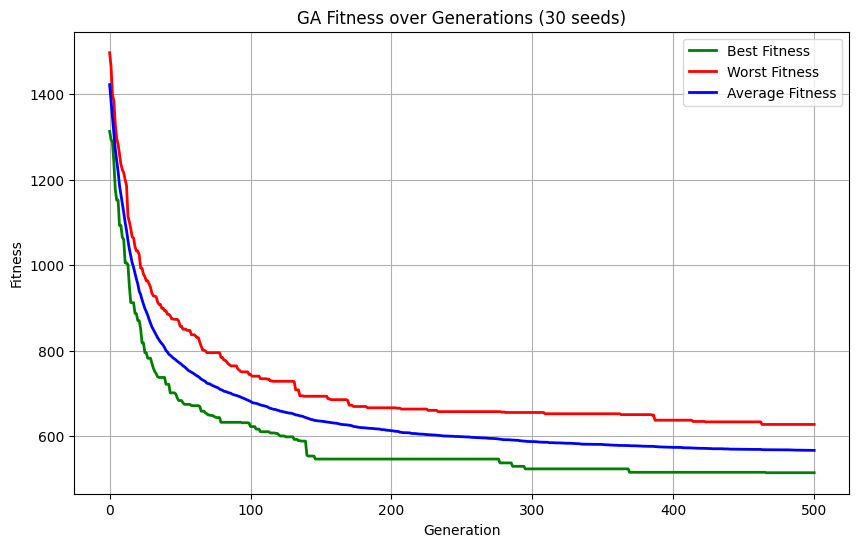

Best overall fitness across all seeds: 514
Worst overall fitness across all seeds: 627
Average fitness across all seeds: 566.23


In [38]:
import numpy as np

all_histories = np.array(all_histories)  # shape: (num_seeds, num_generations+1)

# Tính các chỉ số qua seed
best_per_gen = np.min(all_histories, axis=0)
worst_per_gen = np.max(all_histories, axis=0)
avg_per_gen = np.mean(all_histories, axis=0)

plt.figure(figsize=(10,6))
plt.plot(best_per_gen, label="Best Fitness", color='green', linewidth=2)
plt.plot(worst_per_gen, label="Worst Fitness", color='red', linewidth=2)
plt.plot(avg_per_gen, label="Average Fitness", color='blue', linewidth=2)

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("GA Fitness over Generations (30 seeds)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best overall fitness across all seeds: {best_per_gen[-1]}")
print(f"Worst overall fitness across all seeds: {worst_per_gen[-1]}")
print(f"Average fitness across all seeds: {avg_per_gen[-1]:.2f}")